In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import LabelEncoder

Загрузим датасет

In [3]:
df = pd.read_csv('indian_liver_patient.csv')
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [4]:
df.describe()

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
count,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,579.000000,583.000000
mean,44.746141,3.298799,1.486106,290.576329,80.713551,109.910806,6.483190,3.141852,0.947064,1.286449
std,16.189833,6.209522,2.808498,242.937989,182.620356,288.918529,1.085451,0.795519,0.319592,0.452490
min,4.000000,0.400000,0.100000,63.000000,10.000000,10.000000,2.700000,0.900000,0.300000,1.000000
25%,33.000000,0.800000,0.200000,175.500000,23.000000,25.000000,5.800000,2.600000,0.700000,1.000000
50%,45.000000,1.000000,0.300000,208.000000,35.000000,42.000000,6.600000,3.100000,0.930000,1.000000
75%,58.000000,2.600000,1.300000,298.000000,60.500000,87.000000,7.200000,3.800000,1.100000,2.000000
max,90.000000,75.000000,19.700000,2110.000000,2000.000000,4929.000000,9.600000,5.500000,2.800000,2.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


Проверим столбцы на нули

In [6]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

Посмотрим графическую корреляцию между параметрами

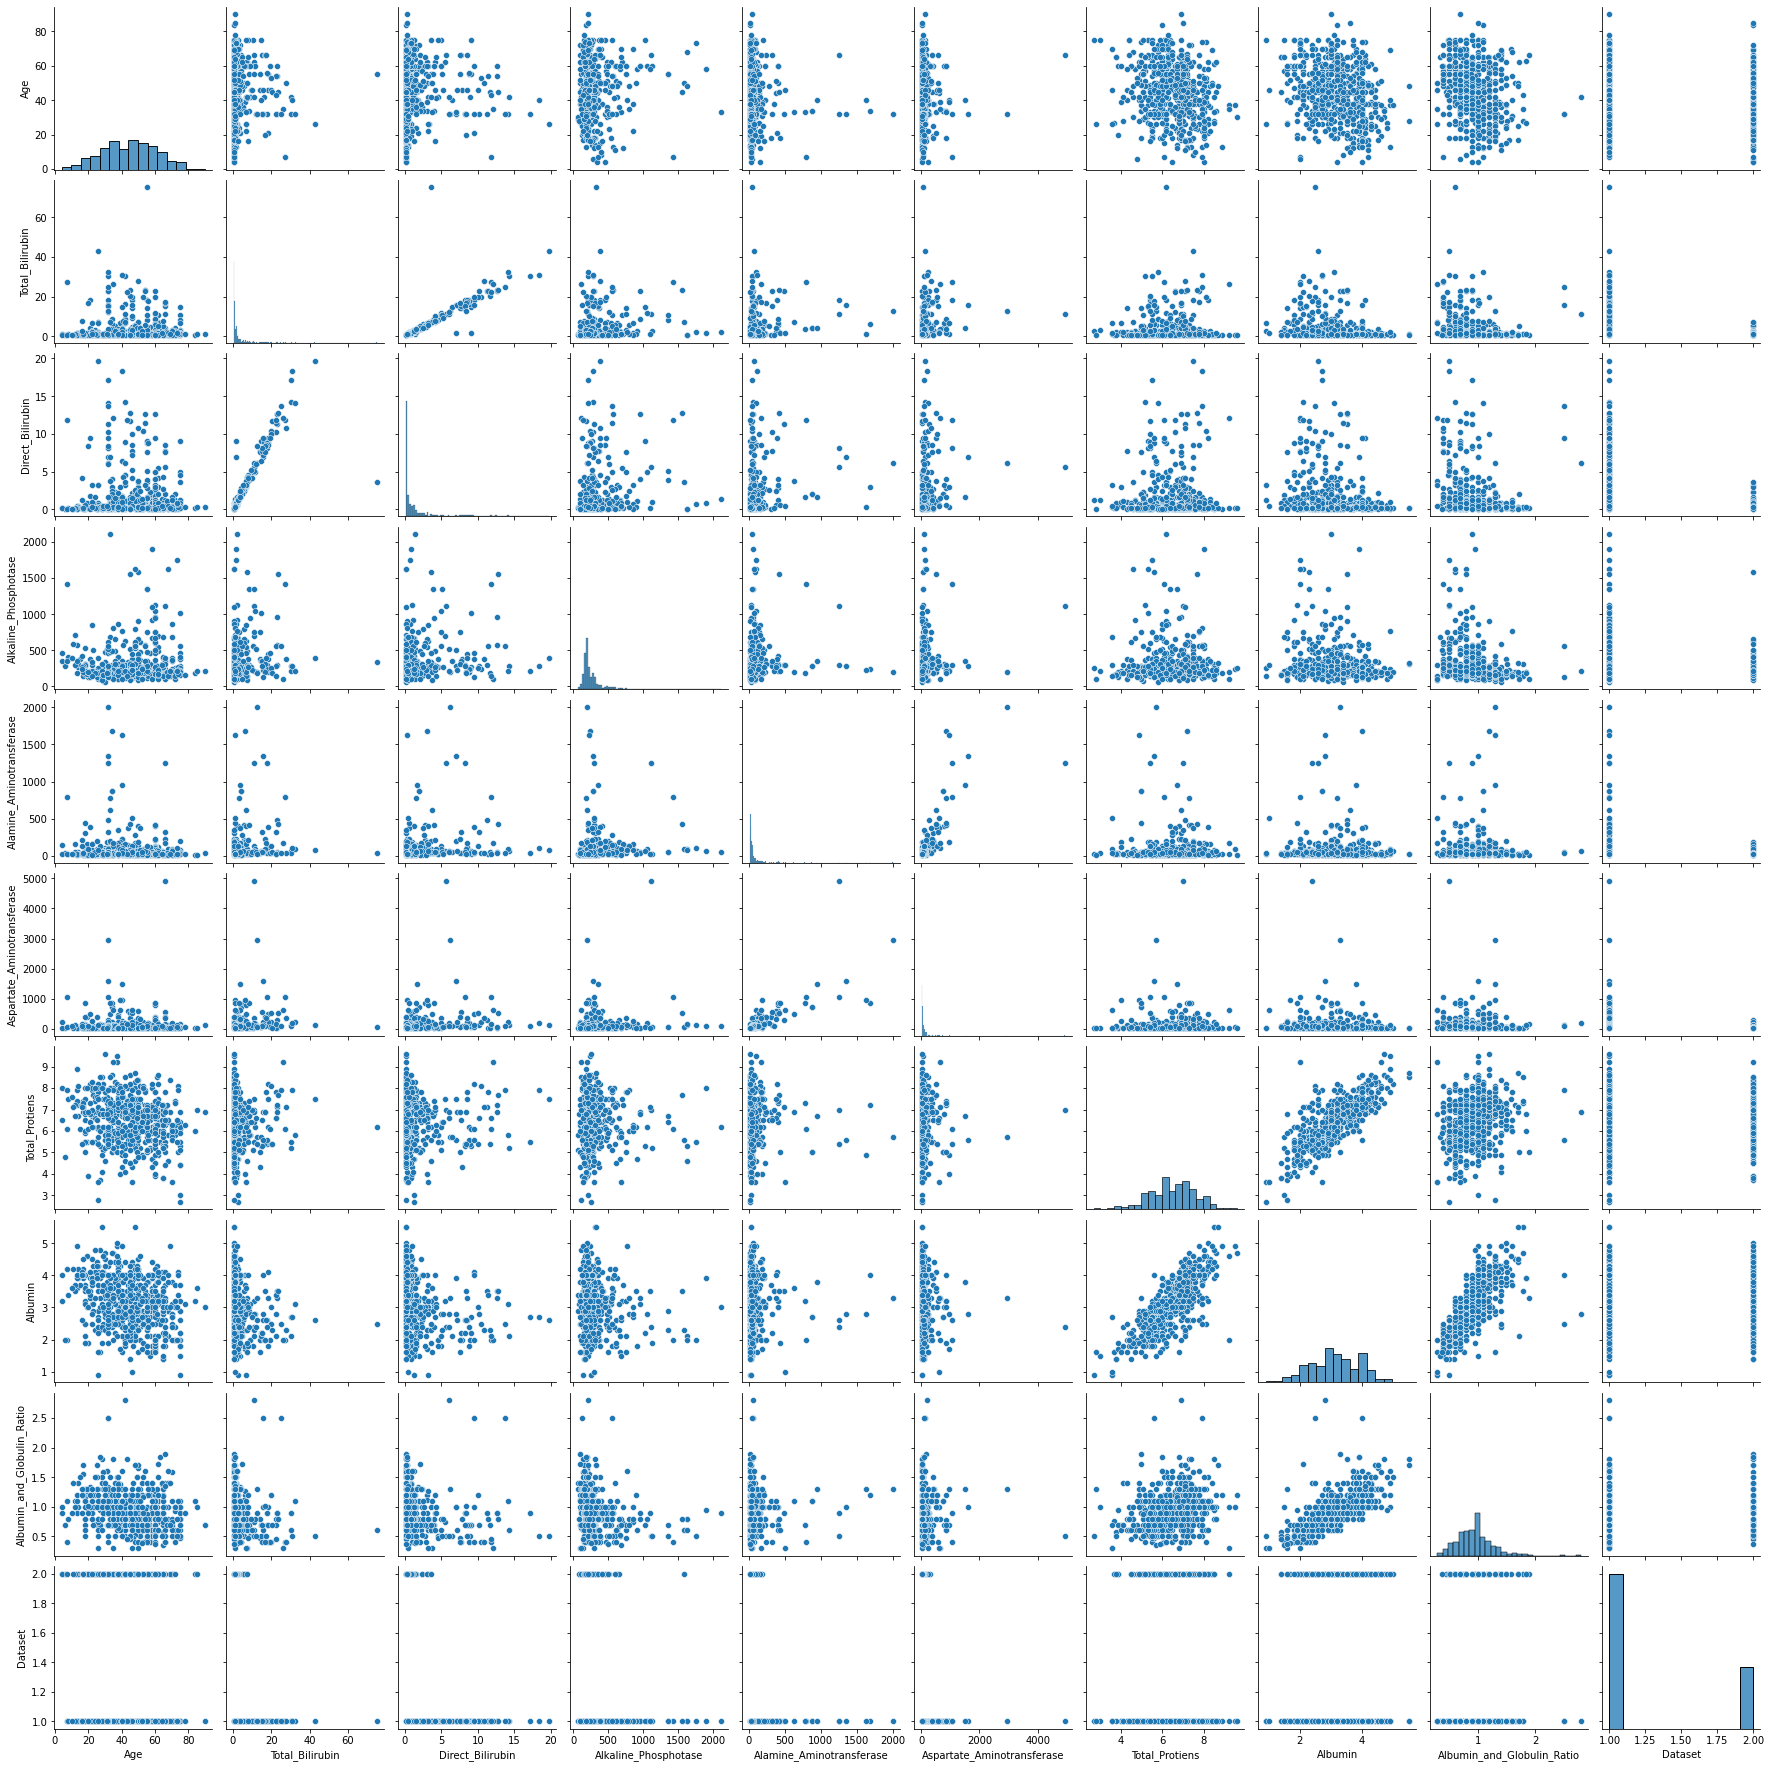

In [12]:
sns.pairplot(df)

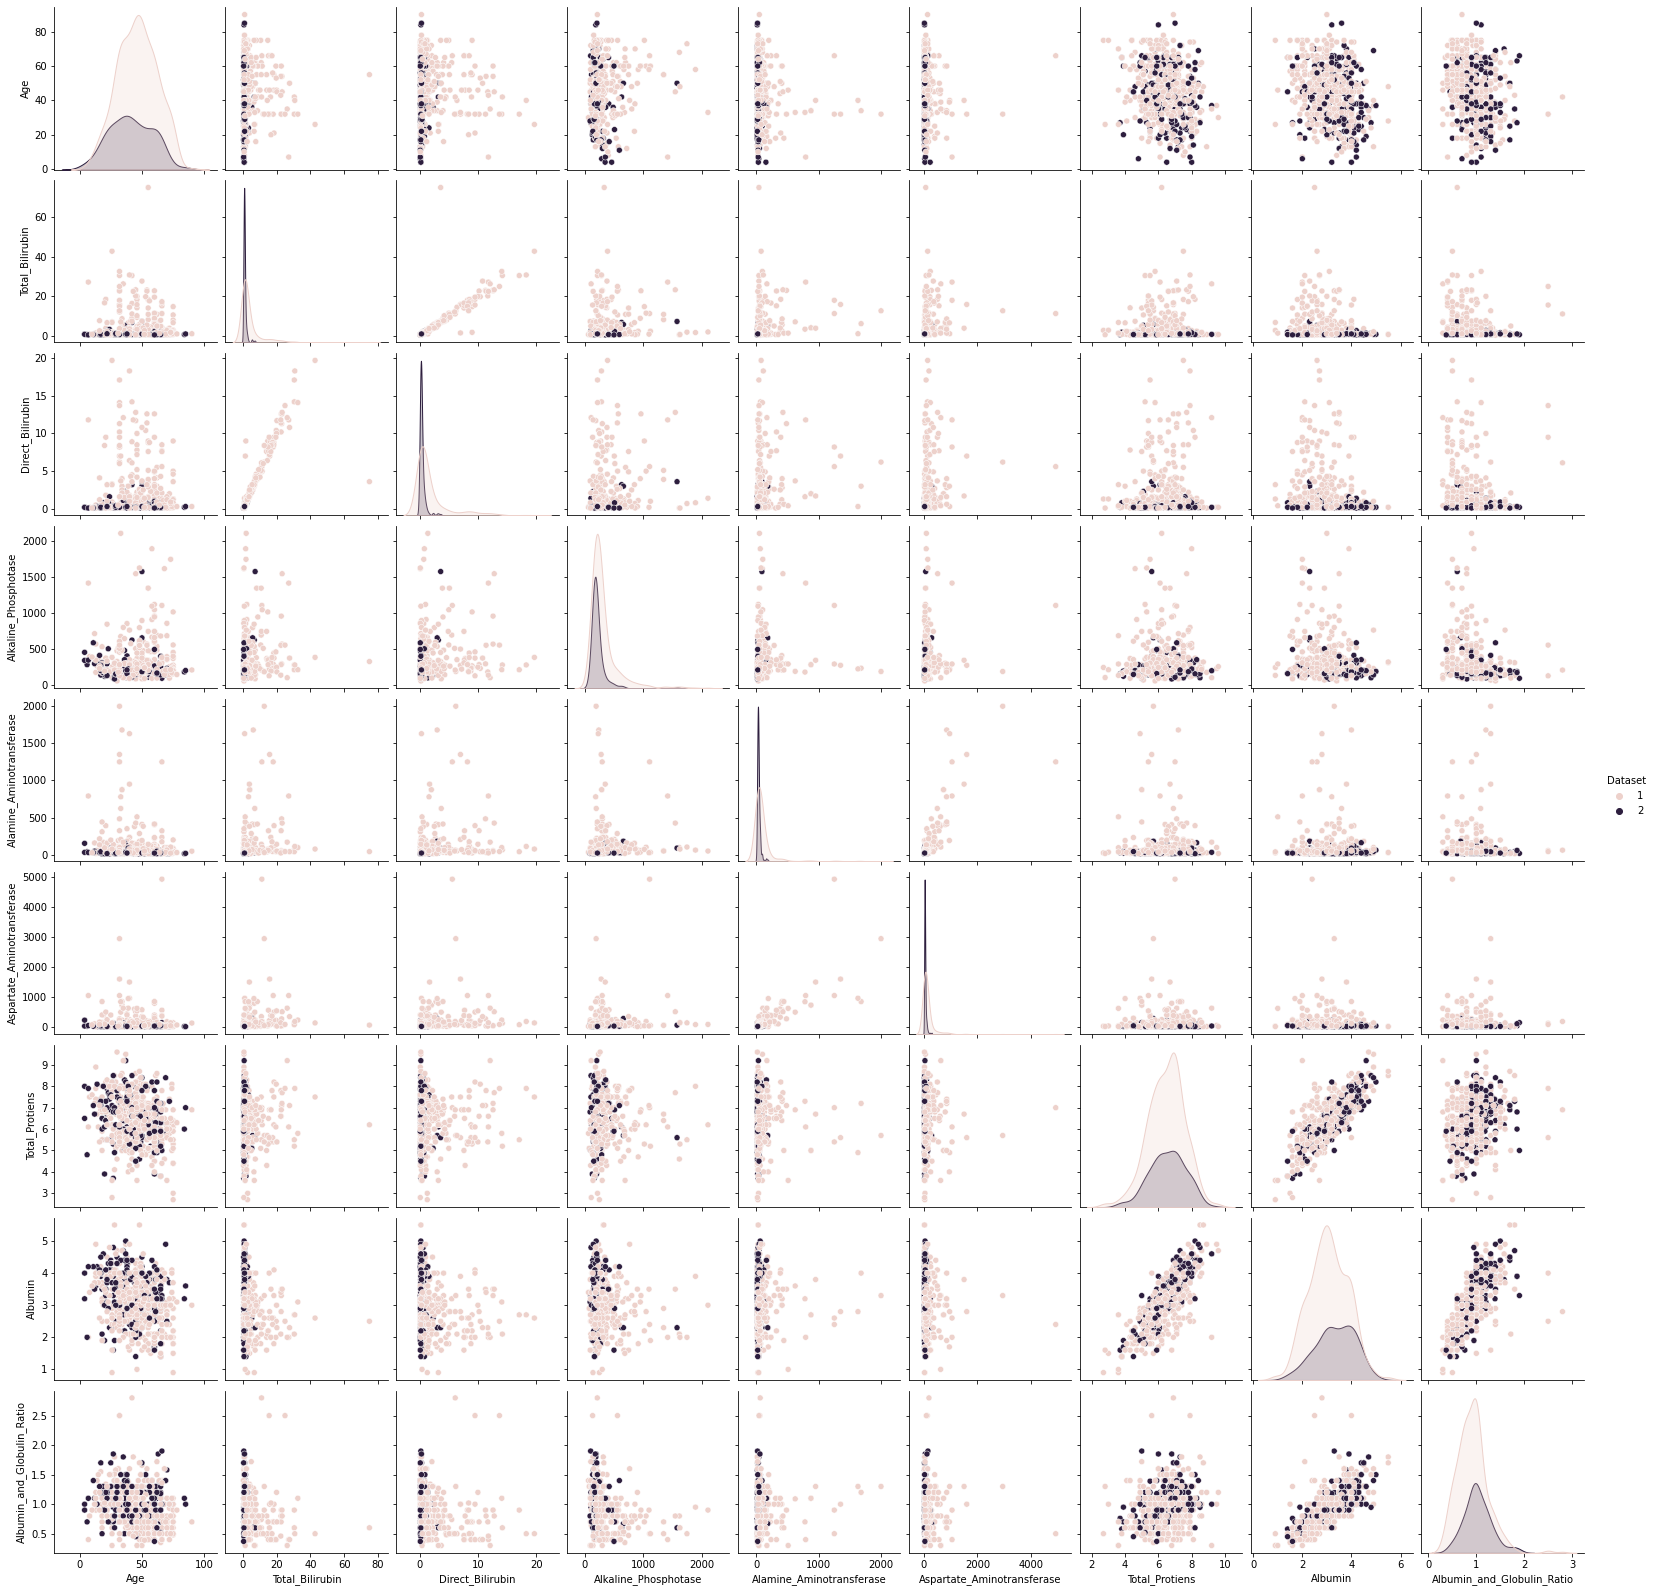

In [13]:
sns.pairplot(df,hue='Dataset')

Посмотрим корреляцию между параметрами

In [14]:
df.corr().style.background_gradient(cmap='inferno')

,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
Age,1.000000,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216089,-0.137351
Total_Bilirubin,0.011763,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206159,-0.220208
Direct_Bilirubin,0.007529,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200004,-0.246046
Alkaline_Phosphotase,0.080425,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.233960,-0.184866
Alamine_Aminotransferase,-0.086883,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002374,-0.163416
Aspartate_Aminotransferase,-0.019910,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070024,-0.151934
Total_Protiens,-0.187461,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.233904,0.035008
Albumin,-0.265924,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.686322,0.161388
Albumin_and_Globulin_Ratio,-0.216089,-0.206159,-0.200004,-0.233960,-0.002374,-0.070024,0.233904,0.686322,1.000000,0.162319
Dataset,-0.137351,-0.220208,-0.246046,-0.184866,-0.163416,-0.151934,0.035008,0.161388,0.162319,1.000000


Есть сильная корреляция между несколькими параметрами:

* Total_Bilirubin и Direct_Bilirubin
* Alamine_Aminotransferase и Aspartate_Aminotransferase
* Total_Protiens и Albumin
* Albumin_and_Globulin_Ratio и Albumin


In [15]:
df.drop(['Albumin','Direct_Bilirubin','Aspartate_Aminotransferase'],axis=1,inplace=True)
df.corr().style.background_gradient(cmap='inferno')

,Age,Total_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Total_Protiens,Albumin_and_Globulin_Ratio,Dataset
Age,1.000000,0.011763,0.080425,-0.086883,-0.187461,-0.216089,-0.137351
Total_Bilirubin,0.011763,1.000000,0.206669,0.214065,-0.008099,-0.206159,-0.220208
Alkaline_Phosphotase,0.080425,0.206669,1.000000,0.125680,-0.028514,-0.233960,-0.184866
Alamine_Aminotransferase,-0.086883,0.214065,0.125680,1.000000,-0.042518,-0.002374,-0.163416
Total_Protiens,-0.187461,-0.008099,-0.028514,-0.042518,1.000000,0.233904,0.035008
Albumin_and_Globulin_Ratio,-0.216089,-0.206159,-0.233960,-0.002374,0.233904,1.000000,0.162319
Dataset,-0.137351,-0.220208,-0.184866,-0.163416,0.035008,0.162319,1.000000


Переведем параметры Gender из male,female в 0,1

In [16]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.Gender.head()

0    0
1    1
2    1
3    1
4    1
Name: Gender, dtype: int64

Разница между кол-вом небольных и больных слишком большая, поэтому нужно сбалансировать данные. Используем для этого resample

In [18]:
from sklearn.utils import resample
minority = df[df.Dataset==2]
majority = df[df.Dataset==1]

minority_upsample = resample(minority, replace=True, n_samples=majority.shape[0])
df = pd.concat([minority_upsample, majority], axis=0)

Приготовим тестовые данные

In [19]:
from sklearn.model_selection import train_test_split
x = df.drop('Dataset',axis=1)
y=df['Dataset']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=101)


Обучим наши модели

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,roc_auc_score

logreg = LogisticRegression()
logreg.fit(x_train,y_train)

y_train_result = logreg.predict(x_train)
y_test_result = logreg.predict(x_test)

print('Оценка тренировочного сета')
print(classification_report(y_train,y_train_result))


print('Оценка тестового сета')
print(classification_report(y_test,y_test_result))

print('Результат ROC кривой')
print(roc_auc_score(y_test, y_test_result))

Оценка тренировочного сета
              precision    recall  f1-score   support

           1       0.81      0.61      0.70       316
           2       0.68      0.85      0.76       308

    accuracy                           0.73       624
   macro avg       0.74      0.73      0.73       624
weighted avg       0.74      0.73      0.73       624

Оценка тестового сета
              precision    recall  f1-score   support

           1       0.80      0.60      0.69       100
           2       0.70      0.86      0.77       108

    accuracy                           0.74       208
   macro avg       0.75      0.73      0.73       208
weighted avg       0.75      0.74      0.73       208

Результат ROC кривой
0.7305555555555556


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
from sklearn.svm  import SVC
from sklearn.metrics import classification_report,roc_auc_score

svc = SVC()
svc.fit(x_train,y_train)

y_train_result = svc.predict(x_train)
y_test_result = svc.predict(x_test)


print('Оценка тренировочного сета')
print(classification_report(y_train,y_train_result))


print('Оценка тестового сета')
print(classification_report(y_test,y_test_result))

print('Результат ROC кривой')
print(roc_auc_score(y_test, y_test_result))

Оценка тренировочного сета
              precision    recall  f1-score   support

           1       0.80      0.55      0.66       316
           2       0.65      0.86      0.74       308

    accuracy                           0.71       624
   macro avg       0.73      0.71      0.70       624
weighted avg       0.73      0.71      0.70       624

Оценка тестового сета
              precision    recall  f1-score   support

           1       0.71      0.55      0.62       100
           2       0.66      0.80      0.72       108

    accuracy                           0.68       208
   macro avg       0.69      0.67      0.67       208
weighted avg       0.68      0.68      0.67       208

Результат ROC кривой
0.6731481481481482


По результатам, ни одна из моделей не переобучена судя по f1, svc имеет лучши е результаты. Апсемплинг помог улучшийть результаты модели.